# Search and homing path figure

Before running this code you need to run:
1. homing_path_data_collection.ipynb
2. search_path_data_collection.ipynb
3. instantaneous_firing_rate.ipynb
4. search_homing_trial_matrix.ipynb



In [1]:
%load_ext autoreload
%autoreload 2

%run ../setup_project.py
%run ../neuronAutopi.py


Project name: autopi_ca1
dataPath: /ext_drives/d80/Jazi_etal_2023/autopi_ca1
Reading /ext_drives/d80/Jazi_etal_2023/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects


In [2]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)
prepareSessionsForSpatialAnalysisProject(sSesList,myProjectWithTrials.sessionList,pose_file_extension = ".pose_kf.npy")

Loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/myProjectWithTrials.pickle
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict
CPU times: user 10.9 s, sys: 2.29 s, total: 13.2 s
Wall time: 13.2 s


In [3]:
myProject.dataPath

'/ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1'

Load the data

In [4]:
#define the font size and the family 
font_properties = {'family': 'Arial', 'size': 7}


# Spike-on-plot for homing and search paths

We want to show what a lever-distance and position neuron looks like in 2D paths.



Plot all the searchToLeverPath 

In [5]:
from scipy.stats import linregress


def plot_spike_on_path_y_sorted_by_lever_y_position(ax, cluId,condition, offset = 40,legend=True):
    font_properties = {'family': 'Arial', 'size': 7}
    cluNo = cluId.split("_")[1]
    session = cluId.split("_")[0]
   

    sSes = [sSes for sSes in sSesList if sSes.name == session][0]
    ses = myProjectWithTrials.getSession(session)

    ifr, navs, inav = load_ifr_behavior(ses)
    
    sSes.ap.set_intervals(ses.intervalDict[condition])
    
    pathType = condition.split("_")[0]
    light = condition.split("_")[1]
    
    trialNos = navs[(navs.type==pathType) & (navs.nLeverPresses >= 1) & (navs.light==light)].trialNo
    leverYs = [ ses.trialList[tn-1].lever.leverCenter[1]  for tn in trialNos]
    
    lev = np.array(leverYs)
    

    sSes.ap.set_intervals(ses.intervalDict[condition])
    for i, rk in enumerate(lev.argsort()):
        inter = ses.intervalDict[condition][rk]
        indices = np.logical_and(sSes.ap.pose[:,0]>=inter[0], sSes.ap.pose[:,0]<=inter[1])
        sSes.ap.pose[indices,1] = sSes.ap.pose[indices,1] + offset*i
    
    n = [n for n in sSes.cg.neuron_list if n.name==cluNo][0]
    n.spike_train.set_intervals(ses.intervalDict[condition])
    spike_posi = n.spatial_properties.spike_position()        
    

    ax.scatter(sSes.ap.pose[:,1],sSes.ap.pose[:,2],s=2, color="lightgray",label="Path")
    ax.scatter(spike_posi[:,0],spike_posi[:,1],s=5,color="red",alpha=0.75,label="Spikes")

    # regression line
    indices = ~np.any(np.isnan(spike_posi),axis=1)
    slope, intercept, _,_,_ = linregress(spike_posi[indices])
    x = np.linspace(np.nanmin(spike_posi[:,0]),np.nanmax(spike_posi[:,0]),2)
    ax.plot(x,x*slope+intercept)

    
    argSort = lev.argsort()
    x = [i*offset for i in range(argSort.shape[0])]
    ax.scatter(x, lev[argSort],color="black",s=5,label="Lever")
    
    
    ax.set_ylabel("Y position",fontsize=7)
    ax.set_xticks([])
    ax.set_xlabel("Trials",fontsize=7)
    ax.set_ylim(-45,40)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(ticks= [],fontproperties=font_properties)
    ax.set_yticks(ticks= range(-40, 41, 20) , npfontproperties=font_properties)
    
    if legend:
        ax.legend()
        ax.legend(prop={'family': 'Arial','size': 7})

In [6]:
list(range(-40, 41, 20))
sizePerRow, sizePerCol = figurePanelDefaultSize()


## Panel a:

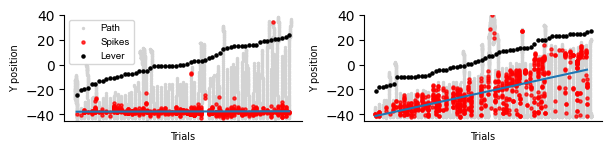

In [7]:
sizePerCol= 3#5
sizePerRow= 1.4# 1.8
col = 2
row = 1
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig)

ax = fig.add_subplot(gs[0])
cluId =  "mn3246-10042021-0106_296" #"mn1173-06052021-0107_116" #"mn3246-12042021-0106_49"#
condition = "searchToLeverPath_light"
plot_spike_on_path_y_sorted_by_lever_y_position(ax,cluId,condition)

ax = fig.add_subplot(gs[1])
cluId =  "mn1173-06052021-0107_26"
condition = "searchToLeverPath_light"
plot_spike_on_path_y_sorted_by_lever_y_position(ax,cluId,condition,legend=False)



In [8]:
myProject.dataPath

'/ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1'

In [9]:
fn=myProject.dataPath+"/results/searchMapDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    mySearchMaps=pickle.load(handle)

# matrices with single trials 
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    searchIFR = pickle.load(handle)

# histogram that are cut at the 90 percentile to cover similar region across conditions
fn=myProject.dataPath+"/results/1DsearchHisto.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    oneDSearchHisto = pickle.load(handle)
    
# statistics of the 1D histograms
fn=myProject.dataPath+"/results/1DsearchHistoStats.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    oneDSearchStats = pickle.load(handle)
    

fn=myProject.dataPath+"/results/homingMapDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    myHomingMaps=pickle.load(handle)

# matrices with single trials 
fn=myProject.dataPath+"/results/homingIFRDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    homingIFR = pickle.load(handle)

# histogram that are cut at the 90 percentile to cover similar region across conditions
fn=myProject.dataPath+"/results/1DhomingHisto.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    oneDHomingHisto = pickle.load(handle)
    
# statistics of the 1D histograms
fn=myProject.dataPath+"/results/1DhomingHistoStats.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    oneDHomingStats = pickle.load(handle)
      
# trial matrix internal correlations
# contains only pyramidal cells 
fn = myProject.dataPath+"/results/trialMatrixCor.csv"
print("loading",fn)
trialMatrixCor = pd.read_csv(fn)
fn = myProject.dataPath+"/results/trialMatrixCorShuf.csv"
print("loading",fn)
trialMatrixCorShuf = pd.read_csv(fn)


fn = myProject.dataPath+"/results/trialMatrixSign.csv"
print("loading",fn)
trialMatrixSign = pd.read_csv(fn)

# Peak position - lever position correlations
fn=myProject.dataPath+"/results/peakPositionLeverPositionCorr.csv"
print("loading",fn)
peakPositionLeverPositionCorr = pd.read_csv(fn)

fn=myProject.dataPath+"/results/leverPeakCorrSign.csv"
print("loading",fn)
leverPeakCorrSign = pd.read_csv(fn)

fn=myProject.dataPath+"/results/trialMatrixStats.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    tmStats = pickle.load(handle)



loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/searchMapDict.pickle
loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/searchIFRDict.pickle
loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/1DsearchHisto.pickle
loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/1DsearchHistoStats.pickle
loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/homingMapDict.pickle
loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/homingIFRDict.pickle
loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/1DhomingHisto.pickle
loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/1DhomingHistoStats.pickle
loading /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/trialMatrixCor.csv
loading /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/trialMatrixCorShuf.csv
loading /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/trialMatrixSign.csv
loading /ext_drives/d80/Ja

In [10]:
fn=myProject.dataPath+"/results/cell_classification_noint.csv"
ct = pd.read_csv(fn)

pyrIndices=ct.cellType=="pyr"
pyrId=ct.id[ct.cellType=="pyr"]
print("Pyramidal cells: {}".format(np.sum(ct.cellType=="pyr")))
print("Pyramidal cells: {}".format(np.sum(pyrIndices)))

Pyramidal cells: 438
Pyramidal cells: 438


In [11]:
res = {}
for k in mySearchMaps.keys():
    res[k] = mySearchMaps[k][pyrIndices]
mySearchMapsSel = res
print(mySearchMapsSel["searchToLeverPath_dark"].shape)

res = {}
for k in myHomingMaps.keys():
    res[k] = myHomingMaps[k][pyrIndices]
myHomingMapsSel = res
print(myHomingMapsSel['homingFromLeavingLeverToPeriphery_light'].shape)

(438, 34, 34)
(438, 34, 34)


In [12]:
mySearchDict={}
for oneId in searchIFR.keys():
    if oneId in list(pyrId):
        mySearchDict.update({oneId:searchIFR[oneId]})
print(len(mySearchDict.keys()))

myHomingDict={}
for oneId in homingIFR.keys():
    if oneId in list(pyrId):
        myHomingDict.update({oneId:homingIFR[oneId]})
print(len(myHomingDict.keys()))

438
438


In [13]:
oneDSearchHistoSel = {}
for k in oneDSearchHisto.keys():
    oneDSearchHistoSel[k] = oneDSearchHisto[k][pyrIndices]

oneDHomingHistoSel = {}
for k in oneDHomingHisto.keys():
    oneDHomingHistoSel[k] = oneDHomingHisto[k][pyrIndices]
    
print(oneDSearchHistoSel['searchToLeverPath_light_distance'].shape)
print(oneDHomingHistoSel['homingFromLeavingLeverToPeriphery_light_distance'].shape)

(438, 15)
(438, 15)


In [14]:
oneDSearchStatsSel = oneDSearchStats[oneDSearchStats.cluId.isin(pyrId)]
oneDHomingStatsSel = oneDHomingStats[oneDHomingStats.cluId.isin(pyrId)]
print(len(oneDSearchStatsSel.cluId.unique()))
print(len(oneDHomingStatsSel.cluId.unique()))
oneDSearchStatsSel["pathType"] = "searchToLeverPath"
oneDHomingStatsSel["pathType"] = "homingFromLeavingLeverToPeriphery"
oneDStats  = pd.concat([oneDSearchStatsSel,oneDHomingStatsSel])
oneDStats

438
438


,session,cluId,light,behavioralVariable,meanRate,info,minX,maxX,peakRate,peakLoc,pathType
2,mn5824-20112020-0107,mn5824-20112020-0107_92,light,distance,14.761577,0.014007,0.0,52.433,14.784263,11,searchToLeverPath
5,mn5824-20112020-0107,mn5824-20112020-0107_100,light,distance,0.740231,0.206911,0.0,52.433,0.831569,6,searchToLeverPath
6,mn5824-20112020-0107,mn5824-20112020-0107_114,light,distance,1.652608,0.157766,0.0,52.433,2.821333,7,searchToLeverPath
7,mn5824-20112020-0107,mn5824-20112020-0107_116,light,distance,0.094681,1.572155,0.0,52.433,0.258257,10,searchToLeverPath
8,mn5824-20112020-0107,mn5824-20112020-0107_118,light,distance,0.068859,0.840414,0.0,52.433,0.091245,0,searchToLeverPath
...,...,...,...,...,...,...,...,...,...,...,...
33,mn9686-01112021-0106,mn9686-01112021-0106_79,dark,y,0.898588,1.309439,-35.0,-1.196,0.930090,3,homingFromLeavingLeverToPeriphery
34,mn9686-01112021-0106,mn9686-01112021-0106_81,dark,y,0.112323,NaN,-35.0,-1.196,0.000000,0,homingFromLeavingLeverToPeriphery
45,mn9686-01112021-0106,mn9686-01112021-0106_197,dark,y,1.444159,1.533666,-35.0,-1.196,1.154550,14,homingFromLeavingLeverToPeriphery
55,mn9686-01112021-0106,mn9686-01112021-0106_242,dark,y,3.690629,0.209269,-35.0,-1.196,4.505805,11,homingFromLeavingLeverToPeriphery


Put the trial matrix correlation with the trial matrix stats

In [15]:
tmc = trialMatrixCor
tmc.rename(columns = {'path':'pathType', 'var':'behavioralVariable'}, inplace = True)
tmStats = pd.merge(tmStats,tmc,on=["cluId","pathType","light","behavioralVariable"])
tmStats.shape

(7008, 12)

# Example of trial matrices of neurons during search and homing path in light and dark trials

We can start the figure by showing example of fields during search-light, search-dark, homing-light, and homing-dark.

For each, we need the path, map and then 4 trial matrices (distance,time,y,leverd istance).


In [16]:
def get_matDic(mainDict,cluId,pathType,light,var):
    """
    get a dictionary with one matrix, bins, and other variables from the dictionary containing all neurons, all conditions
    
    We set a few keys in the dictionary that can be used when ploting and processing.
    """
    matDic = {}
    matDic["matrix"] = mainDict[cluId]["matrix"]["{}_{}_{}".format(pathType,light,var)]["matrix"].copy()
    matDic["bins"] = mainDict[cluId]["matrix"]["{}_{}_{}".format(pathType,light,var)]["bins"].copy()
    
    matDic["pathType"] = pathType
    matDic["light"] = light
    matDic["var"] = var
    matDic["cluId"] = cluId
    return matDic


def trimTrailingMatrixNanColumn(matDict):
    """
    Removes columns of the matrix that are filled with np.nan. 
    Only removes columns that are after the last column containing valid values
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    nRows = m.shape[0]
    nCols = m.shape[1]
    emptyCol = np.sum(np.isnan(m),axis=0) == nRows
    if np.sum(emptyCol) > 0:
        lastNotEmpty = np.max(np.where(emptyCol==0))
        m = m[:,:lastNotEmpty+1]
        bins = bins[:lastNotEmpty+2]
    
    matDict["matrix"] = m
    matDict["bins"] = bins
    return matDict
    
def removeEmptyTrials(matDict):
    """
    Remove any trials that have only np.nan values
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    matDict["matrix"] = m[np.sum(~np.isnan(m),axis=1)>0,:]
    return matDict
    
    
def cutExtremelyLongTrials(matDict, minNumberValidValues=10):
    """
    Identify the longest trials of the session and remove the values at the end so that there is at least minNumberValidValues in each column of the matrix
    
    This was implemented to prevent that a single very long trial compromise the detection of the peak firing rate location calculated from all trials. 
    
    This procedure makes sure that one spike in a very long path will not be detected as the peak location in the matrix. Each value will be the average of a few trials.
    
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    def myFct(x):
        if np.sum(x) > 0 :
            return np.max(np.where(x)[0])
        else:
            return 0
        
    lastValidValueInRow = np.apply_along_axis(myFct, axis=1,arr = ~np.isnan(m))
    sortedValid = np.sort(lastValidValueInRow)
    threshold = sortedValid[-minNumberValidValues]
    
    matDict["matrix"] = m[:,:threshold+1]
    matDict["bins"] = bins[:threshold+2]
    return matDict


In [17]:
def pathsPlot(gs,cellId,pathType="searchToLeverPath",light="light"):
    """
    Plot every navPath in the specified type and light condition
    """
    sessionName=cellId.split("_")[0]
    mySes = myProjectWithTrials.getSession(sessionName=sessionName)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0])    
    ax = fig.add_subplot(gs1[0])
    mySes.plotNavPath(ax=ax,navPathType=pathType,light=light)
         
def plotMap(ax,myMap,title="",titleY=0.95):
    """
    Plot one 2D map
    """
    ax.imshow(myMap.T,origin="lower",cmap='jet',interpolation=None)
    ax.set_title(title,y=titleY)
    ax.axis('off')

def mapPlot(ax,cellId,myMaps,searchIFR,pathType="searchToLeverPath", light="light",cmPerBin=3):
    """
    Call this function to get the map for a specific path and light condition
    """
    
    index=np.argmax([ k==cellId for k in searchIFR.keys()])
    myMap=myMaps["{}_{}".format(pathType,light)][index]
    
    toRem = 3 # pixels to remove at extremeties
    plotMap(ax,myMap[toRem:-toRem,toRem:-toRem],title="{:.2f} Hz".format(np.nanmax(myMap)),titleY=0.95)
    
    midCoord = np.array([myMap.shape[0]/2,myMap.shape[1]/2 ])
    angles = np.linspace(0,np.pi*2,100)
    x = np.cos(angles)*40/cmPerBin+midCoord[1]-toRem -1
    y = np.sin(angles)*40/cmPerBin+midCoord[0]-toRem -1
    ax.plot(x,y,color="gray")
    
    x = np.cos(angles)*40*0.925/cmPerBin+midCoord[1]-toRem -1
    y = np.sin(angles)*40*0.925/cmPerBin+midCoord[0]-toRem -1
    ax.plot(x,y,color="gray",linestyle="--")
    
      
        
def plotIFRMatrix(ax,cellId,myIFR,pathType="searchToLeverPath",light="light",dv="y",sort=True,showYLabel=True,yAxisX=-0.4,plotFiringRatePeaks = False):
    """
    Call this function to get the trial matrix
    """
    condNames={"targetDistance":"Lever dist. (cm)",
               "y": "Y-axis coord. (cm)",
               "iTime": "Time (sec)",
               "distanceProp":"Distance run (Prop)",
               "distance": "Distance run (cm)"}
    
    tmc = trialMatrixCor[(trialMatrixCor.cluId==cellId)&(trialMatrixCor.light==light)&(trialMatrixCor.behavioralVariable==dv)&(trialMatrixCor.pathType==pathType)].cor.values[0]
    
    cond = "{}_{}_{}".format(pathType,light,dv)
    oneMat = get_matDic(myIFR,cellId,pathType,light,dv)
    oneMat = trimTrailingMatrixNanColumn(oneMat)
    oneMat = cutExtremelyLongTrials(oneMat)
    
    
    
    m = oneMat["matrix"]
    
    # remove bins to the right for which we don't have any valid values
    colToRemove = np.all(np.isnan(m),axis=0)
    rem = np.argmax(~np.flip(colToRemove))
    if rem > 0:
        m = m[:,:-rem]
    
    
    if sort:
        m = m[np.argsort(-np.sum(np.isnan(m),axis=1))]
        oneMat["matrix"] = m
    
    #gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0])    
    #ax = fig.add_subplot(gs1[0])  
    
    plotIFRMat(ax,oneMat ,showXLabel=True,xLabel=condNames[dv],showYLabel=showYLabel,title="r = {:.2f}".format(tmc),yAxisX=yAxisX,plotFiringRatePeaks = plotFiringRatePeaks)
    
def plotIFRMat(ax,m ,showXLabel=True,xLabel="",showYLabel=True,title="",titleY=0.95,yAxisX=-0.4,plotFiringRatePeaks=False):
    """
    Plot the matrix of rate per journey as a function of distance to lever
    """
    ax.imshow(m['matrix'],aspect="auto",interpolation="none",extent=[np.min(m["bins"]),np.max(m["bins"]),0,m["matrix"].shape[0]],origin="lower",cmap="jet")
    if showYLabel:
        ax.set_ylabel("Paths")
    else:
        ax.set_ylabel("")
    if showXLabel:
        ax.set_xlabel(xLabel)
    else:
        ax.set_xlabel("")
    ax.yaxis.set_label_coords(yAxisX, 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    ax.text(0.45,0.04,title,fontsize=10,transform=ax.transAxes)
    if plotFiringRatePeaks:
        steps = m["bins"][1] - m["bins"][0]
        midBins = m["bins"][:-1]+steps/2
        peakLoc = midBins[np.nanargmax(m["matrix"],axis=1)]
        ax.scatter(peakLoc,np.arange(0,peakLoc.shape[0])+0.5,color="red",s=15,marker="|")
    
    

def exampleOneNeuron(gs,cellId,pathType,light,showPath=True,matrixYAxisX=-0.4,behavioralVariables=None):
    """
    Plot a summary that gives us an idea of what a neuron is doing in a pathType-light condition
    
    """
    if showPath:
        if behavioralVariables is None:
            col=6
        else:
            col=2+len(behavioralVariables)
        ratios = [1]+[1.3]+[1]*(col-2)  
        gsExample = gridspec.GridSpecFromSubplotSpec(1, col, subplot_spec=gs[0], width_ratios=ratio) # used for matrix
        
    else:
        if behavioralVariables is None:
            col=5
        else:
            col=1+len(behavioralVariables)
        ratios = [1.3]+[1]*(col-1)
        gsExample = gridspec.GridSpecFromSubplotSpec(1, col, subplot_spec=gs[0], width_ratios=ratios) # used for matrix
            
    index = 0
    
    if showPath:
        gs22 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsExample[index]) # get the first column
        pathsPlot(gs22,cellId,pathType=pathType,light=light)
        index+=1

    gsForMap =  gridspec.GridSpecFromSubplotSpec(1, col, subplot_spec=gsExample[index:],width_ratios=[1.2]+[1]*(col-1-index))  # use for map
    
    index+=1
    if pathType=="searchToLeverPath":
        myMaps = mySearchMaps
    else:
        myMaps = myHomingMaps
    ax = fig.add_subplot(gsForMap[0])
    mapPlot(ax,cellId,myMaps,searchIFR = searchIFR, pathType=pathType,light=light)


    if pathType=="searchToLeverPath":
        myIFR = searchIFR
    else:
        myIFR = homingIFR
    
    if behavioralVariables is None:
        behavioralVariables = ["distance","iTime","y","targetDistance"]
    
    
    for i, var in enumerate(behavioralVariables):
        
        ax =  fig.add_subplot(gsExample[i+index])
        if i == 0:
            
            plotIFRMatrix(ax,cellId,myIFR, pathType=pathType, light=light,dv=var,showYLabel=True,yAxisX=matrixYAxisX,plotFiringRatePeaks=False)
        else: 
            plotIFRMatrix(ax,cellId,myIFR, pathType=pathType, light=light,dv=var,showYLabel=False,yAxisX=matrixYAxisX)
        
        

And now we can plot our examples. 

We will only show examples for the 4 conditions. We want to give the reader an idea of the firing fields as the mouse moves around on the arena.

In [18]:
def plotExamplesFewCells(gs,cellIds,pathType,light):
    """
    Plot the 2d firing rate map and the trial matrices
    """
    
    gsPerCells = gridspec.GridSpecFromSubplotSpec(len(cellIds), 1, subplot_spec=gs[0]) 
    
    for i,cellId in enumerate(cellIds):
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPerCells[i]) # get the first column
        exampleOneNeuron(gs1,cellId,pathType,light,showPath=False,behavioralVariables=["y","targetDistance"],matrixYAxisX=-0.25)

def plotExamplesFewCellsWithTitle(gs,cellIds,pathType,light,title="myTitle"):
    """
    Wrapper to plot example of neurons with a title at the top
    """
    gsTwo = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],height_ratios=[0.05,1])
    
    ax = fig.add_subplot(gsTwo[0])
    ax.text(0.5,0.5,title,fontsize=16,ha='center', va='center',transform=ax.transAxes)
    ax.axis('off')
    
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsTwo[1])
    plotExamplesFewCells(gs1,cellIds,pathType,light)
    

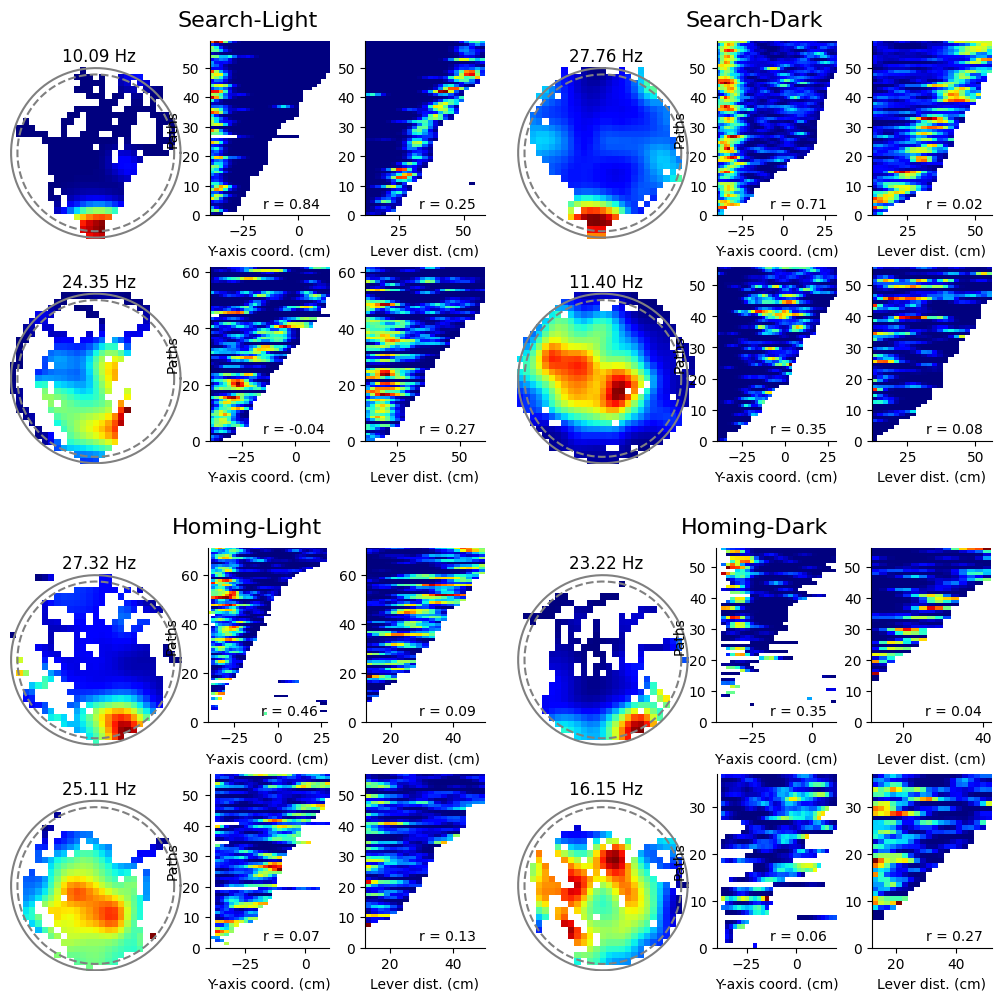

In [19]:
def plotExamplesFourConditions(gs):
    myDict={"Search-Light":{"cellIds": [ "mn3246-10042021-0106_296","mn1173-06052021-0107_26"],
                         "pathType": "searchToLeverPath",
                         "light": "light"},
           "Search-Dark":{"cellIds": ["mn3246-10042021-0106_244","mn1173-06052021-0107_116"],
                         "pathType": "searchToLeverPath",
                         "light": "dark"},
           "Homing-Light":{"cellIds": [ "mn3246-12042021-0106_49","TYY5622-17092021-0106_41"],
                         "pathType": "homingFromLeavingLeverToPeriphery",
                         "light": "light"},
           "Homing-Dark":{"cellIds": ["mn1173-06052021-0107_99","mn711-31012021-0107_44"],
                         "pathType": "homingFromLeavingLeverToPeriphery",
                         "light": "dark"},
          }
    
    
    gsFour = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0],width_ratios=[1,0.05,1],height_ratios=[1,0.05,1])
    #gsFour = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0],width_ratios=[1,0.3,1],height_ratios=[1,0.05,1])
    for i, cond in enumerate(myDict.keys()):
        x = int(i/2)
        y = int(i%2)
        if x > 0:
            x = x+1
        if y > 0:
            y = y+1
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsFour[x,y])
        
        plotExamplesFewCellsWithTitle(gs1,
                                      myDict[cond]["cellIds"],
                                      myDict[cond]["pathType"],
                                      myDict[cond]["light"],
                                      title=cond)

col=5.5
row=5.5

sizePerRow, sizePerCol = figurePanelDefaultSize()
#sizePerRow, sizePerCol = 2,2
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure
plotExamplesFourConditions(gs)
    
    

# Location of y-coord. and lever distance fields

We often see sharp firing fields as the animal enters the arena. Fields in the center of the arena are wider.


In [20]:
activeThreshold=2.0
peakFieldThreshold=10

df = tmStats[(tmStats.pathType=="homingFromLeavingLeverToPeriphery") & (tmStats.behavioralVariable.isin(["y","targetDistance"])) & (tmStats.light=="dark")]
dfw = df.pivot(index=["cluId"],columns="behavioralVariable")
df = dfw.reset_index(drop=False)

active_Indices = (df["meanRate"]["y"] > activeThreshold)
print("Active neurons homing-dark: {} out of {}".format(np.sum(active_Indices),dfw.shape[0]))


Active neurons homing-dark: 197 out of 438


Proportion of neurons that are active during the 4 types of navPath considered.

In [21]:
count = 0
chiMatActive = np.empty((4,2))
chiMatField = np.empty((4,2))
for pathType in ["searchToLeverPath","homingFromLeavingLeverToPeriphery"]:
    for light in ["light","dark"]:
        df = tmStats[(tmStats.pathType==pathType) & (tmStats.behavioralVariable.isin(["y"])) & (tmStats.light==light)]
        dfw = df.pivot(index=["cluId"],columns="behavioralVariable")
        df = dfw.reset_index(drop=False)
        
        neurons = len(df["meanRate"]["y"])
        active_Indices = (df["meanRate"]["y"] > activeThreshold)
        inactive_Indices = (df["meanRate"]["y"] <= activeThreshold)
        activeWithField_Indices = active_Indices & (df["maxRateInHisto"]["y"] > peakFieldThreshold)
        activeWithoutField_Indices = active_Indices & (df["maxRateInHisto"]["y"] <= peakFieldThreshold)
        
        print(pathType,light,"Number of neurons:",neurons, "Active neurons:",np.sum(active_Indices),
              "Prop. active:",np.sum(active_Indices)/neurons,"Neurons with fields:",np.sum(activeWithField_Indices), 
              "Neurons without fields:",np.sum(activeWithoutField_Indices))
        chiMatActive[count,0]=np.sum(active_Indices)
        chiMatActive[count,1]=np.sum(inactive_Indices)
        
        chiMatField[count,0]=np.sum(activeWithField_Indices)
        chiMatField[count,1]=np.sum(activeWithoutField_Indices)
        
        
        count=count+1
        
chiMatActive, chiMatField

searchToLeverPath light Number of neurons: 438 Active neurons: 226 Prop. active: 0.5159817351598174 Neurons with fields: 104 Neurons without fields: 122
searchToLeverPath dark Number of neurons: 438 Active neurons: 212 Prop. active: 0.4840182648401826 Neurons with fields: 94 Neurons without fields: 118
homingFromLeavingLeverToPeriphery light Number of neurons: 438 Active neurons: 191 Prop. active: 0.4360730593607306 Neurons with fields: 109 Neurons without fields: 82
homingFromLeavingLeverToPeriphery dark Number of neurons: 438 Active neurons: 197 Prop. active: 0.4497716894977169 Neurons with fields: 112 Neurons without fields: 85


(array([[226., 212.],
        [212., 226.],
        [191., 247.],
        [197., 241.]]),
 array([[104., 122.],
        [ 94., 118.],
        [109.,  82.],
        [112.,  85.]]))

Chi-square test to know whether the number of active cells differs across condition.

In [22]:
from scipy.stats import chisquare
chisquare(chiMatActive[:,0])

Power_divergenceResult(statistic=3.588377723970944, pvalue=0.309479420429741)

In [23]:
chisquare(chiMatField[:,0])

Power_divergenceResult(statistic=1.7828162291169452, pvalue=0.6186814372456457)

### Distribution of trial matrix correlations

In [24]:
def plotTrialMatrixInternalCorrelation2(gs,df,title="Hey",legend=False):

    #dfSel = df[df.pathType==pathType]
    myDict={"ylabel":{"cor":"Trial matrix corr."},
           "yMax":{"cor":0.2},
            "xTicksValues": ["Search", "Homing"]
           }
    ax = fig.add_subplot(gs[0])
    sns.barplot(hue = "light", y = "cor", x = "pathType", data = df, hue_order=["dark","light"],
                order=['searchToLeverPath','homingFromLeavingLeverToPeriphery'],palette=darkLightColors(), alpha=0.8)
    sns.stripplot(hue = "light", y = "cor", x = "pathType", data = df, hue_order=["dark","light"],
                  order=['searchToLeverPath','homingFromLeavingLeverToPeriphery'], palette=darkLightColors(), dodge=True, size=7) ## maryam added
    ax.set_ylabel(myDict["ylabel"]["cor"])
    ax.set_xlabel("")
    ax.set_ylim(0,myDict["yMax"]["cor"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(myDict["xTicksValues"], rotation= 0,ha = "center")
    if legend:
        ax.legend(loc=0, frameon=False)
    else:
        ax.legend([],[], frameon=False)
    ax.set_title(title)
    
def plotTrialMatrixCorrelationTwoVariables(gs,df,minRate=2.0):
    
    myTitleDict = {"y": "Y-coordinate",
                  "targetDistance": "Lever distance"}
    gsPlots = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
    for i,behavioralVariable in enumerate(["y","targetDistance"]):
        
        df1 = df[(df.behavioralVariable==behavioralVariable)]
        gsOnePlot = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[i])
        plotTrialMatrixInternalCorrelation2(gsOnePlot,df=df1,title=myTitleDict[behavioralVariable])
        

calculate the trial matrix correlation for each variable per mice

In [25]:
tmStats['subject']= [cid.split('-')[0] for cid in tmStats.cluId]
dfm=tmStats.groupby(['subject','light','pathType','behavioralVariable']).mean().reset_index()


/tmp/ipykernel_1920659/3282432594.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfm=tmStats.groupby(['subject','light','pathType','behavioralVariable']).mean().reset_index()


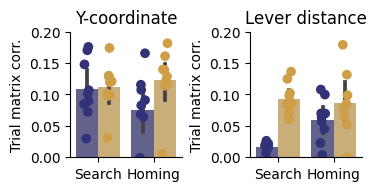

In [26]:
col=2
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure
plotTrialMatrixCorrelationTwoVariables(gs,df=dfm) ## to calculate per cells df= tmStats


## Stats:

In [27]:
from scipy.stats import wilcoxon,ttest_rel

In [28]:
wilcoxon_cond1 = [
    (dfm.pathType=='homingFromLeavingLeverToPeriphery')&(dfm.light=='light')&(dfm.behavioralVariable=='y'),
    (dfm.pathType=='searchToLeverPath')&(dfm.light=='light')&(dfm.behavioralVariable=='y'),
    (dfm.pathType=='searchToLeverPath')&(dfm.light=='dark')&(dfm.behavioralVariable=='y'),
    (dfm.pathType=='homingFromLeavingLeverToPeriphery')&(dfm.light=='light')&(dfm.behavioralVariable=='targetDistance'),
    (dfm.pathType=='searchToLeverPath')&(dfm.light=='light')&(dfm.behavioralVariable=='targetDistance'),
    (dfm.pathType=='homingFromLeavingLeverToPeriphery')&(dfm.light=='dark')&(dfm.behavioralVariable=='targetDistance')
]

wilcoxon_cond2 = [
    (dfm.pathType=='homingFromLeavingLeverToPeriphery')&(dfm.light=='dark')&(dfm.behavioralVariable=='y') ,
    (dfm.pathType=='searchToLeverPath')&(dfm.light=='dark')&(dfm.behavioralVariable=='y'),
    (dfm.pathType=='homingFromLeavingLeverToPeriphery')&(dfm.light=='dark')&(dfm.behavioralVariable=='y'),
    (dfm.pathType=='homingFromLeavingLeverToPeriphery')&(dfm.light=='dark')&(dfm.behavioralVariable=='targetDistance'),
    (dfm.pathType=='searchToLeverPath')&(dfm.light=='dark')&(dfm.behavioralVariable=='targetDistance'),
    (dfm.pathType=='searchToLeverPath')&(dfm.light=='dark')&(dfm.behavioralVariable=='targetDistance')
]

condNames=['Homing_light_y_VS_Homing_dark_y', 'Search_light_y_VS_Search_dark_y','Search_dark_y_VS_Homing_dark_y',
          'Homing_light_targetToDis_VS_Homing_dark_targetToDis','Search_light_TargetToDis_VS_Search_dark_TargetToDis',
          'Homing_dark_targetToDis_VS_Search_dark_TargetToDis']
for cond1, cond2, conds in zip(wilcoxon_cond1, wilcoxon_cond2, condNames):
    print(conds)
    stats, p = wilcoxon(dfm.cor[cond1], dfm.cor[cond2])
    print(stats, p)

Homing_light_y_VS_Homing_dark_y
0.0 0.00390625
Search_light_y_VS_Search_dark_y
22.0 1.0
Search_dark_y_VS_Homing_dark_y
0.0 0.00390625
Homing_light_targetToDis_VS_Homing_dark_targetToDis
7.0 0.07421875
Search_light_TargetToDis_VS_Search_dark_TargetToDis
0.0 0.00390625
Homing_dark_targetToDis_VS_Search_dark_TargetToDis
0.0 0.00390625


### Distribution of information scores

In [29]:
def plotInfoScore(gs,df,title="Hey",legend=False):

   
    dfSel = df[df.pathType==pathType]
    myDict={"ylabel":{"info":"Info score"},
           "yMax":{"info":0.3},
            "xTicksValues": ["Search", "Homing"]
           }
    ax = fig.add_subplot(gs[0])

    sns.barplot(hue = "light", y = "info", x = "pathType", data = df, hue_order=["dark","light"], 
                order=['searchToLeverPath','homingFromLeavingLeverToPeriphery'],palette=darkLightColors(),alpha=0.8)
    sns.stripplot(hue = "light", y = "info", x = "pathType", data = df, hue_order=["dark","light"],
                  order=['searchToLeverPath','homingFromLeavingLeverToPeriphery'],palette=darkLightColors(), size=7, dodge=True)
    ax.set_ylabel(myDict["ylabel"]["info"])
    ax.set_xlabel("")
    #
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(myDict["xTicksValues"], rotation= 0,ha = "center")
    if legend:
        ax.legend(loc=0, frameon=False)
    else:
        ax.legend([],[], frameon=False)
    ax.set_title(title)
    
def plotInfoScoreTwoVariables(gs,df,minRate=2.0):
    
    myTitleDict = {"y": "Y-axis coordinate",
                  "targetDistance": "Lever distance"}
    gsPlots = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
    for i,behavioralVariable in enumerate(["y","targetDistance"]):
        
        df1 = df[(df.behavioralVariable==behavioralVariable) & (df.meanRate>minRate)]
        gsOnePlot = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[i])
        plotInfoScore(gsOnePlot,df=df1,title=myTitleDict[behavioralVariable])


In [30]:
oneDStats['subject']= [ses.split('-')[0] for ses in oneDStats.session]
oneDStatsm= oneDStats.groupby(['subject','light','behavioralVariable','pathType']).mean().reset_index()
oneDStatsm.shape

/tmp/ipykernel_1920659/3359968685.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oneDStatsm= oneDStats.groupby(['subject','light','behavioralVariable','pathType']).mean().reset_index()


(144, 10)

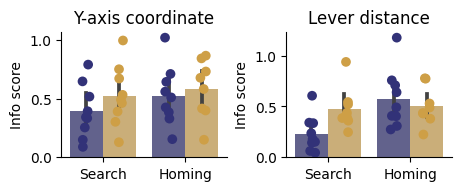

In [31]:
col=2.5
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()

fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure
plotInfoScoreTwoVariables(gs,df=oneDStatsm) ## 

# Stats for information score:

In [32]:
wilcoxon_cond1 = [
    (oneDStatsm.light=='light')&(oneDStatsm.pathType=='homingFromLeavingLeverToPeriphery')&(oneDStatsm.behavioralVariable=='y'),
    (oneDStatsm.light=='light')&(oneDStatsm.pathType=='searchToLeverPath')&(oneDStatsm.behavioralVariable=='y'),
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='homingFromLeavingLeverToPeriphery')&(oneDStatsm.behavioralVariable=='y'),
    (oneDStatsm.light=='light')&(oneDStatsm.pathType=='homingFromLeavingLeverToPeriphery')&(oneDStatsm.behavioralVariable=='targetDistance'),
    (oneDStatsm.light=='light')&(oneDStatsm.pathType=='searchToLeverPath')&(oneDStatsm.behavioralVariable=='targetDistance'),
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='homingFromLeavingLeverToPeriphery')&(oneDStatsm.behavioralVariable=='targetDistance')
]

wilcoxon_cond2 = [
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='homingFromLeavingLeverToPeriphery')&(oneDStatsm.behavioralVariable=='y') ,
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='searchToLeverPath')&(oneDStatsm.behavioralVariable=='y'),
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='searchToLeverPath')&(oneDStatsm.behavioralVariable=='y'),
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='homingFromLeavingLeverToPeriphery')&(oneDStatsm.behavioralVariable=='targetDistance'),
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='searchToLeverPath')&(oneDStatsm.behavioralVariable=='targetDistance'),
    (oneDStatsm.light=='dark')&(oneDStatsm.pathType=='searchToLeverPath')&(oneDStatsm.behavioralVariable=='targetDistance')
]

condNames=['Homing_light_y_VS_Homing_dark_y','Search_light_y_VS_Search_dark_y','Homing_dark_y_VS_Search_dark_y',
           'Homing_light_targetToDis_VS_Homing_dark_targetToDis','Search_light_TargetToDis_VS_Search_dark_TargetToDis',
           'Homing_dark_TargetToDis_VS_Search_dark_TargetToDis']
for cond1, cond2, conds in zip(wilcoxon_cond1, wilcoxon_cond2, condNames):
    print(conds)
    stats, p = wilcoxon(oneDStatsm['info'][cond1], oneDStatsm['info'][cond2])
    print(stats, p)

Homing_light_y_VS_Homing_dark_y
9.0 0.12890625
Search_light_y_VS_Search_dark_y
4.0 0.02734375
Homing_dark_y_VS_Search_dark_y
1.0 0.0078125
Homing_light_targetToDis_VS_Homing_dark_targetToDis
18.0 0.65234375
Search_light_TargetToDis_VS_Search_dark_TargetToDis
0.0 0.00390625
Homing_dark_TargetToDis_VS_Search_dark_TargetToDis
0.0 0.00390625


In [33]:
def statRow(gs):
    gsPlots = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
    
    gsPlotOne = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[0])
    plotTrialMatrixCorrelationTwoVariables(gsPlotOne,df=dfm)
    gsPlotTwo = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[1])
    plotInfoScoreTwoVariables(gsPlotTwo,df=oneDStatsm) ### (oer cells df=oneDStat)

# Panels c and d:

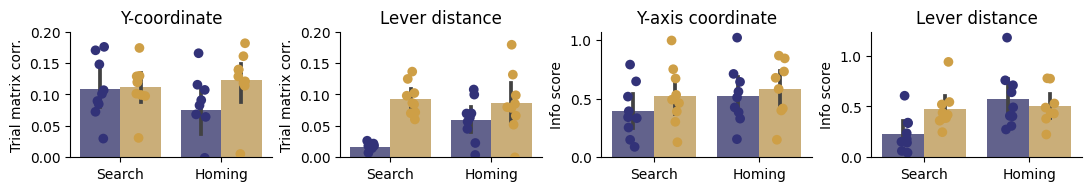

In [34]:
col=6
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gsStats = gridspec.GridSpec(1, 1, figure=fig) # all our figure
statRow(gsStats)


Examples
Stats


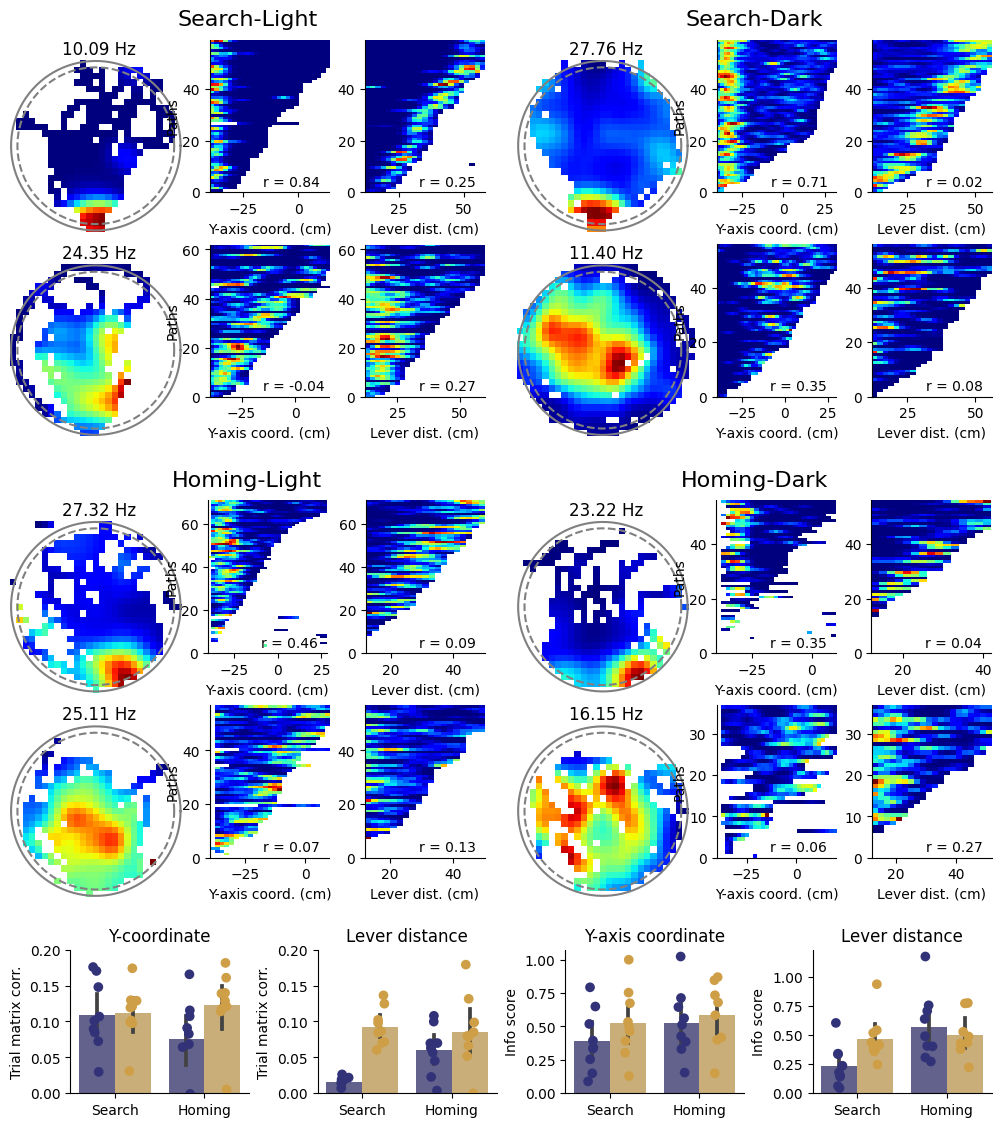

In [35]:
##################
# Panels c and d:
##################
col=5.5
row=6.2
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 

gsPlots = gridspec.GridSpec(3, 1, figure=fig,height_ratios=[5,0.1,1.1]) # all our figure

print("Examples")
gsOnePlotx = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[0])
plotExamplesFourConditions(gsOnePlotx)
    
print("Stats")
gsOnePloty = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[2])
statRow(gsOnePloty)

# Plot lever position / peak rate correlation

We need a plot to explain this analysis with examples.

In [36]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from numba import jit

@jit()
def myOwnCorr2(x,y):
    """
    This one assumes that there are no np.nan
    """
    if np.all(x==0):
        return np.nan
    if np.all(y==0):
        return np.nan   
    else :
        return np.corrcoef(x,y)[0,1]

def trialPeakLeverPosPlot(gs, cluId,pathType,coordX,light,showTrialMatrixR=False,matrixYAxisX=-0.4):
    
    nCol = 4
    
    if showTrialMatrixR:
        nCol+=1
    
    gs0 = gridspec.GridSpecFromSubplotSpec(1, nCol, subplot_spec=gs[0])
    
    sessionName = cluId.split("_")[0]
    ses = myProjectWithTrials.sessionList[[ses.name == sessionName for ses in myProjectWithTrials.sessionList].index(True)]
    ifr, navs, inav = load_ifr_behavior(ses)
    navsSel = navs[(navs.type==pathType) & (navs.light==light)]
    trialDf = ses.getTrialVariablesDataFrame()
    navsSel = pd.merge(navsSel,trialDf,on = "trialNo")
    #print("navsSel shape:",navsSel.shape)
    navsSel
    
    # get the original trial map
    if pathType == "searchToLeverPath":
        myDict = mySearchDict
    else:
        myDict = myHomingDict
    m = myDict[cluId]["matrix"][pathType+"_"+light+"_"+coordX]["matrix"].copy()
    nTrials = m.shape[0]
    
    if m.shape[0] != navsSel.shape[0]:
        print("m and navsSel shapes do not match {} {}".format(m.shape[0],navsSel.shape[0]))
        
    # cut the matrix so that the trials ends at the longest trial of this type
    nBins = m.shape[1]
    minIndex = np.where(~np.all(np.isnan(m),axis=0))[0].min() # first column with valid value
    maxIndex = np.where(~np.all(np.isnan(m),axis=0))[0].max() # last column with valid value
    m = m[:,minIndex:maxIndex+1]
    nBinsKept = m.shape[1]
    
    # trial selection if needed
    trialToKeep = ~np.all(np.isnan(m),axis=1) # remove a trial if all firing rate values are np.nan
    trialToKeep = np.logical_and(np.abs(navsSel.homingErrorAtPeriphery) < (np.pi/4),trialToKeep)   # this should give 90 degree range centered on the home base
    
    #print("Keeping {} of {} trials, {} of {} bins".format(np.sum(trialToKeep),nTrials,nBinsKept,nBins))
   
    # get the firing rate peak location for each trial
    m = m[trialToKeep]
    peakLoc = np.nanargmax(m,axis=1)*2 # *2 because every bin is 2 cm
  
  
    # get the y lever position
    leverY= navsSel.leverY.to_numpy()[trialToKeep]
    
   
    r =  myOwnCorr2(leverY,peakLoc)
    model = LinearRegression()
    model.fit(leverY.reshape(-1,1),peakLoc)
    inter = model.intercept_
    slope = model.coef_[0]
    
    x = np.linspace(leverY.min(),leverY.max(),100)
    y = x*slope+inter
    
    
    
    #### plot the trial matrix
    if pathType=="searchToLeverPath":
        myIFR = searchIFR
    else:
        myIFR = homingIFR
    ax = fig.add_subplot(gs0[0]) # get the first column
    plotIFRMatrix(ax,cluId,myIFR, pathType=pathType, light=light,dv=coordX,yAxisX=matrixYAxisX,plotFiringRatePeaks=False)
        
    
    ax = fig.add_subplot(gs0[1]) # get the first column
    plotIFRMatrix(ax,cluId,myIFR, pathType=pathType, light=light,dv="targetDistance",yAxisX=matrixYAxisX)
    
    
    #### plot the correlation
    ax = fig.add_subplot(gs0[2])
    ax.scatter(leverY,peakLoc, s=7)
    ax.plot(x,y,c="grey",alpha=0.5)
    ax.text(0.1,0.8,"r = {:.2f}".format(r),transform=ax.transAxes)
   # ax.text(0.1,0.8,"inter:{:.2f}".format(inter),transform=ax.transAxes)
   # ax.text(0.1,0.7,"slope:{:.2f}".format(slope),transform=ax.transAxes)
    ax.set_xlabel("Lever loc. (cm)")
    ax.set_ylabel("Peak rate loc.")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    #### plot the real r value and the shuffled r values
    pathType="homingFromLeavingLeverToPeriphery"
    df = peakPositionLeverPositionCorr
    condIndex = (df["cluId"]==cluId)&(df["light"]==light)&(df["pathType"]==pathType)&(df["shuf"]==True)
    shufR = df[condIndex].cor
    ax = fig.add_subplot(gs0[3])
    res = ax.hist(shufR, label="Shuf. r")
    maxY=np.max(res[0])
    ax.plot([r,r],[0,maxY],color="red", label="Obs. r")
    lowSignLevel = np.percentile(shufR,5.0)
    highSignLevel = np.percentile(shufR,95.0)
    ax.plot([lowSignLevel,lowSignLevel],[0,maxY],color="grey",linestyle="dotted")
    ax.plot([highSignLevel,highSignLevel],[0,maxY],color="grey",linestyle="dotted")
    ax.set_xlim(-0.2,1)
    ax.set_xlabel("Peak-Lever corr. (r)")
    ax.set_ylabel("Frequency")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=True,loc=(0.01,0.01))
    
    #### Spatial selectivity
    if showTrialMatrixR:
        df = trialMatrixCor
        condIndex = (df["cluId"]==cluId)&(df["light"]==light)&(df["path"]==pathType)&(df["var"]=="y")
        tmic = df[condIndex].cor.values[0]
        df = trialMatrixCorShuf
        condIndex = (df["cluId"]==cluId)&(df["light"]==light)&(df["path"]==pathType)&(df["var"]=="y")
        tmicShuf = df[condIndex].cor
        ax = fig.add_subplot(gs0[4])

        res = ax.hist(tmicShuf, label="Shuf. r")
        maxY=np.max(res[0])
        ax.plot([tmic,tmic],[0,maxY],color="red", label="Obs. r")
        lowSignLevel = np.percentile(tmicShuf,5.0)
        highSignLevel = np.percentile(tmicShuf,95.0)
        ax.plot([lowSignLevel,lowSignLevel],[0,maxY],color="grey",linestyle="dotted")
        ax.plot([highSignLevel,highSignLevel],[0,maxY],color="grey",linestyle="dotted")
        #ax.set_xlim(-0.2,1)
        ax.set_xlabel("Trial matrix corr. (r)")
        ax.set_ylabel("Frequency")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False)


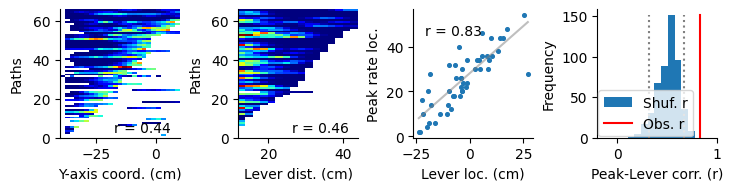

In [37]:
###############
## Panel e
################
col=4
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, figure=fig) # all our figure




gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1])
pathType="homingFromLeavingLeverToPeriphery"
light="dark"
cluId="mn9686-27102021-0106_36" #cellSelection["{}-{}".format(pathType,light)].iloc[30]
trialPeakLeverPosPlot(gs=gs1,cluId=cluId,pathType=pathType,coordX="y",light=light,matrixYAxisX=-0.3)

### Cell selection

Because the analysis uses peak rate of single trials, we need neurons with higher firing rate peak that presumably fire on most trials. 

That is why we need to only include neurons with high peak rate. 

We can also select neurons with a significant trial matrix internal correlation either with y or lever distance.


In [38]:
trialMatrixSign.columns

Index(['Unnamed: 0', 'cluId', 'homingFromLeavingLeverToPeriphery-light-y',
       'homingFromLeavingLeverToPeriphery-light-targetDistance',
       'searchToLeverPath-light-y', 'searchToLeverPath-light-targetDistance',
       'homingFromLeavingLeverToPeriphery-dark-y',
       'homingFromLeavingLeverToPeriphery-dark-targetDistance',
       'searchToLeverPath-dark-y', 'searchToLeverPath-dark-targetDistance'],
      dtype='object')

In [39]:
oneDSearchStatsSel["pathType"] = "searchToLeverPath"
oneDHomingStatsSel["pathType"] = "homingFromLeavingLeverToPeriphery"
oneDStats  = pd.concat([oneDSearchStatsSel,oneDHomingStatsSel])
oneDStats
df = oneDStats


In [40]:
peakRateThreshold=7.5

cellSelection={}
for i, (light,pathType) in enumerate(zip(["light","light","dark","dark"],["searchToLeverPath","homingFromLeavingLeverToPeriphery","searchToLeverPath","homingFromLeavingLeverToPeriphery"])):
    # cells with peak above 10 Hz in y map
    rateSelected1 = df.cluId[(df["light"]==light)&(df["pathType"]==pathType)&(df["behavioralVariable"]=="y")&(df["peakRate"]>peakRateThreshold)]
    # cells with peak above 10 Hz in targetDistance map
    rateSelected2 = df.cluId[(df["light"]==light)&(df["pathType"]==pathType)&(df["behavioralVariable"]=="targetDistance")&(df["peakRate"]>peakRateThreshold)]
    
    rateSelected = pd.concat([rateSelected1,rateSelected2]).unique()
     
    
    # cells with significant trial matrix internal correlation for y or lever distance
    matrixSelected = trialMatrixSign[(trialMatrixSign["{}-{}-{}".format(pathType,light,"y")]) | (trialMatrixSign["{}-{}-{}".format(pathType,light,"targetDistance")])].cluId
    
    
    cellSelection[pathType+"-"+light] = pd.Series(rateSelected[pd.Series(rateSelected).isin(matrixSelected)])

In [41]:
for k in cellSelection.keys():
    print(k)
    print(len(cellSelection[k]))

searchToLeverPath-light
104
homingFromLeavingLeverToPeriphery-light
82
searchToLeverPath-dark
105
homingFromLeavingLeverToPeriphery-dark
73


In [42]:
for cond in cellSelection.keys():
    print(cond)
    cs = cellSelection[cond]
    si = leverPeakCorrSign.cluId[leverPeakCorrSign[cond]==True]


searchToLeverPath-light
homingFromLeavingLeverToPeriphery-light
searchToLeverPath-dark
homingFromLeavingLeverToPeriphery-dark


Get the number of significant neurons out of the spatially selective neurons active in a given condition. 

light (82,) homingFromLeavingLeverToPeriphery
light (104,) searchToLeverPath
dark (73,) homingFromLeavingLeverToPeriphery
dark (105,) searchToLeverPath


/tmp/ipykernel_1920659/3398408620.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],
/tmp/ipykernel_1920659/3398408620.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],


,light,pathType,percentageSign,nSign,nSel
0,Light,Homing,0.256098,21,82
0,Light,Search,0.221154,23,104
0,Dark,Homing,0.273973,20,73
0,Dark,Search,0.085714,9,105


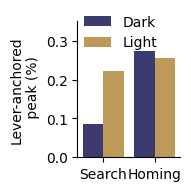

In [43]:
#########
## Panel F
##############
def plotSignLeverAnchoredCells(gs,showLegend=True):

    signDf = pd.DataFrame()
    pathTypeNames = {"searchToLeverPath":"Search",
                    "homingFromLeavingLeverToPeriphery":"Homing"}

    for light in ["light","dark"]:
        for pathType in ["homingFromLeavingLeverToPeriphery", "searchToLeverPath"]:        
            cs = cellSelection["{}-{}".format(pathType,light)]
            print(light,cs.shape,pathType)
            si = leverPeakCorrSign.cluId[leverPeakCorrSign["{}-{}".format(pathType,light)]==True]
            nSign=np.sum(cs.isin(si))
            nSel = len(cs)
            signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],
                                                 "pathType":[pathTypeNames[pathType]],
                                                 "percentageSign":[nSign/nSel],
                                                 "nSign":[nSign],
                                                 "nSel": [nSel] }))
    
    #print(signDf)
    ax = fig.add_subplot(gs[0])
    sns.barplot(x="pathType",y="percentageSign",hue="light",data=signDf,order=["Search","Homing"],hue_order=["Dark","Light"],palette=darkLightColors())
    ax.set_ylim(0,0.35)
    ax.set_ylabel("Lever-anchored\n peak (%)")
    ax.set_xlabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if showLegend:
        ax.legend(loc=(0.005,0.75), frameon=False)
    return signDf

col=1
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()

fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure

plotSignLeverAnchoredCells(gs)

In [44]:
cellSelection

{'searchToLeverPath-light': 0      mn5824-22112020-0107_110
 1      mn5824-22112020-0107_138
 2      mn5824-22112020-0107_245
 3      mn5824-24112020-0107_100
 4      mn5824-24112020-0107_124
                  ...           
 99     mn9686-01112021-0106_246
 100    mn2739-16022021-0106_172
 101     mn2739-17022021-0106_15
 102     mn1173-06052021-0107_44
 103    mn5618-12072021-0110_506
 Length: 104, dtype: object,
 'homingFromLeavingLeverToPeriphery-light': 0     mn5824-22112020-0107_110
 1     mn5824-22112020-0107_116
 2     mn5824-22112020-0107_186
 3     mn5824-24112020-0107_114
 4     mn5824-24112020-0107_124
                 ...           
 77     mn9686-01112021-0106_20
 78     mn9686-01112021-0106_27
 79    mn1173-02052021-0107_125
 80    TYY5622-19092021-0106_27
 81     mn9686-28102021-0107_46
 Length: 82, dtype: object,
 'searchToLeverPath-dark': 0       mn5824-20112020-0107_92
 1      mn5824-20112020-0107_122
 2      mn5824-22112020-0107_110
 3      mn5824-22112020-0107_116


In [45]:
signDf = pd.DataFrame()
pathTypeNames = {"searchToLeverPath":"Search",
                "homingFromLeavingLeverToPeriphery":"Homing"}

for light in ["light","dark"]:
    for pathType in ["homingFromLeavingLeverToPeriphery", "searchToLeverPath"]:        
        cs = cellSelection["{}-{}".format(pathType,light)]
        si = leverPeakCorrSign.cluId[leverPeakCorrSign["{}-{}".format(pathType,light)]==True]
        nSign=np.sum(cs.isin(si))
        nSel = len(cs)
        signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],
                                             "pathType":[pathTypeNames[pathType]],
                                             "percentageSign":[nSign/nSel],
                                             "nSign":[nSign],
                                             "nSel": [nSel],
                                              "nNonSign":[nSel-nSign]}))
signDf

/tmp/ipykernel_1920659/3964436195.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],
/tmp/ipykernel_1920659/3964436195.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],


,light,pathType,percentageSign,nSign,nSel,nNonSign
0,Light,Homing,0.256098,21,82,61
0,Light,Search,0.221154,23,104,81
0,Dark,Homing,0.273973,20,73,53
0,Dark,Search,0.085714,9,105,96


In [46]:
# get the percentage
print('search_light')
print(signDf.nSign[(signDf.light=="Light") & (signDf.pathType=="Search")].values[0]/ signDf.nSel[(signDf.light=="Light") & (signDf.pathType=="Search")].values[0])

print('search_dark')
print(signDf.nSign[(signDf.light=="Dark") & (signDf.pathType=="Search")].values[0]/ signDf.nSel[(signDf.light=="Dark") & (signDf.pathType=="Search")].values[0])

print('Homing_light')
print(signDf.nSign[(signDf.light=="Light") & (signDf.pathType=="Homing")].values[0]/ signDf.nSel[(signDf.light=="Light") & (signDf.pathType=="Homing")].values[0])

print('Homing_dark')
print(signDf.nSign[(signDf.light=="Dark") & (signDf.pathType=="Homing")].values[0]/ signDf.nSel[(signDf.light=="Dark") & (signDf.pathType=="Homing")].values[0])


search_light
0.22115384615384615
search_dark
0.08571428571428572
Homing_light
0.25609756097560976
Homing_dark
0.273972602739726


In [47]:
from scipy.stats import chi2_contingency
table = np.array([[176, 230], [21035, 21018]])
res = chi2_contingency(table)
res[1]

0.008655478161175739

In [48]:
LH = [signDf.nSign[(signDf.light=="Light") & (signDf.pathType=="Homing")].values[0],signDf.nNonSign[(signDf.light=="Light") & (signDf.pathType=="Homing")].values[0]]
DH = [signDf.nSign[(signDf.light=="Dark") & (signDf.pathType=="Homing")].values[0],signDf.nNonSign[(signDf.light=="Dark") & (signDf.pathType=="Homing")].values[0]]
LS = [signDf.nSign[(signDf.light=="Light") & (signDf.pathType=="Search")].values[0],signDf.nNonSign[(signDf.light=="Light") & (signDf.pathType=="Search")].values[0]]
DS = [signDf.nSign[(signDf.light=="Dark") & (signDf.pathType=="Search")].values[0],signDf.nNonSign[(signDf.light=="Dark") & (signDf.pathType=="Search")].values[0]]


In [49]:
LS

[23, 81]

In [50]:
DS

[9, 96]

In [51]:
from scipy.stats import chisquare

print("chi-square Search / light-dark")
print(chi2_contingency(np.array([LS, DS])))
      
print("chi-square Homing / light-dark")
print(chi2_contingency(np.array([LH,  DH])))
          
print("chi-square Search-Dark vs 5%")
print(chi2_contingency( np.array([DS,  [5,100]])))

print("chi-square SD vs HD")
print(chi2_contingency(np.array([DS,  DH])))

chi-square Search / light-dark
(6.383956093268196, 0.011515646887164518, 1, array([[15.92344498, 88.07655502],
       [16.07655502, 88.92344498]]))
chi-square Homing / light-dark
(0.004821146288994677, 0.9446437882151262, 1, array([[21.69032258, 60.30967742],
       [19.30967742, 53.69032258]]))
chi-square Search-Dark vs 5%
(0.6887755102040817, 0.4065811875884089, 1, array([[ 7., 98.],
       [ 7., 98.]]))
chi-square SD vs HD
(9.852828092842294, 0.0016957087560649433, 1, array([[17.10674157, 87.89325843],
       [11.89325843, 61.10674157]]))


Examples
Stats
example lever anchored
light (82,) homingFromLeavingLeverToPeriphery
light (104,) searchToLeverPath
dark (73,) homingFromLeavingLeverToPeriphery
dark (105,) searchToLeverPath


/tmp/ipykernel_1920659/3398408620.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],
/tmp/ipykernel_1920659/3398408620.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signDf = signDf.append(pd.DataFrame({"light":[light.capitalize()],


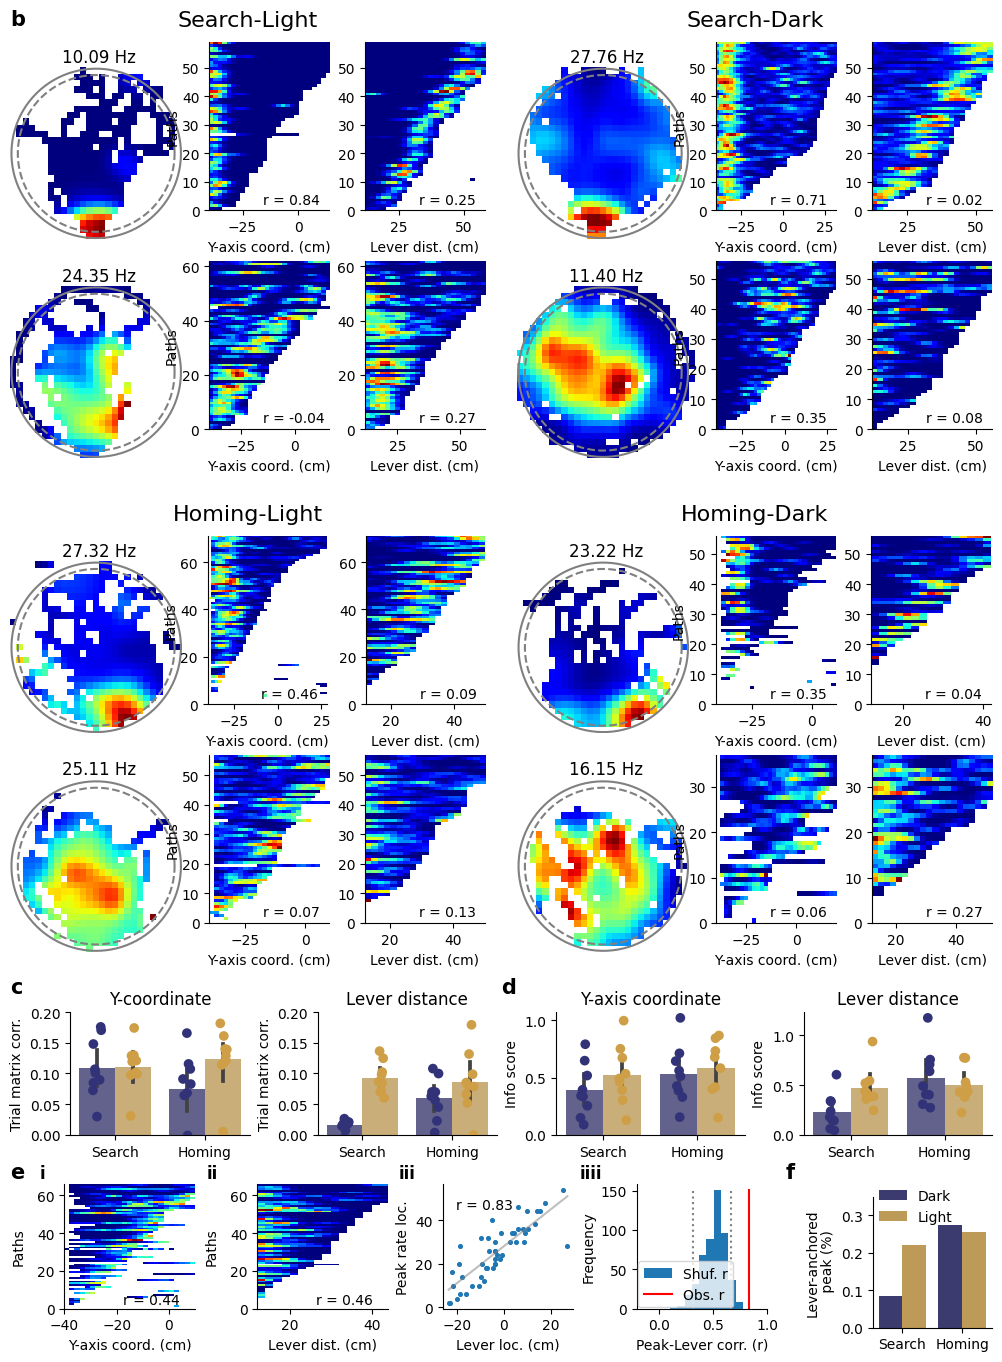

In [52]:
col=5.5
row=7.5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure

gsPlots = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs[0],height_ratios=[5.5,0.1,1,0.1,1])

print("Examples")
gsOnePlotx = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[0])
plotExamplesFourConditions(gsOnePlotx)
    
print("Stats")
gsOnePloty = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlots[2])
statRow(gsOnePloty)


print("example lever anchored")

pathType="homingFromLeavingLeverToPeriphery"
light="dark"
cluId="mn9686-27102021-0106_36" #cellSelection["{}-{}".format(pathType,light)].iloc[30]
gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gsPlots[4,0],width_ratios=[4,0.1,1])
gs20 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs2[0])
trialPeakLeverPosPlot(gs=gs20,cluId=cluId,pathType=pathType,coordX="y",light=light,matrixYAxisX=-0.3)



gs22 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs2[2])
plotSignLeverAnchoredCells(gs22)


ax = fig.add_subplot(gs[0])
ax.text(0.0,1.0, 'b', style='normal',fontsize=15, weight="bold")
ax.text(0.0,0.27, 'c', style='normal',fontsize=15, weight="bold")
ax.text(0.5,0.27, 'd', style='normal',fontsize=15, weight="bold")
ax.text(0.0,0.13, 'e', style='normal',fontsize=15, weight="bold")
ax.text(0.79,0.13, 'f', style='normal',fontsize=15, weight="bold")

ax.text(0.03,0.13, 'i', style='normal',fontsize=12, weight="bold")
ax.text(0.20,0.13, 'ii', style='normal',fontsize=12, weight="bold")
ax.text(0.395,0.13, 'iii', style='normal',fontsize=12, weight="bold")
ax.text(0.58,0.13, 'iiii', style='normal',fontsize=12, weight="bold")

ax.axis("off")
fn= '/home/maryam/Desktop/Ca1_final/fig4/fig4_bf.pdf'
fig.savefig(fn, dpi=300,transparent=True, bbox_inches='tight' )